## 1. Import Dependencies and Data

In [140]:
!pip install matplotlib tensorflow-datasets ipywidgets

In [141]:
!pip list

Package                  Version
------------------------ ---------------
absl-py                  1.1.0
anyio                    3.6.1
appnope                  0.1.3
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
asttokens                2.0.5
astunparse               1.6.3
attrs                    21.4.0
Babel                    2.10.2
backcall                 0.2.0
beautifulsoup4           4.11.1
bleach                   5.0.0
cached-property          1.5.2
cachetools               5.2.0
certifi                  2022.5.18.1
cffi                     1.15.0
charset-normalizer       2.0.12
cycler                   0.11.0
debugpy                  1.6.0
decorator                5.1.1
defusedxml               0.7.1
dill                     0.3.5.1
entrypoints              0.4
etils                    0.6.0
executing                0.8.3
fastjsonschema           2.15.3
flatbuffers              1.12
fonttools                4.33.3
functorch                0.3.0a0+2b16530
ga

In [142]:
import tensorflow as tf

# Limiting GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [143]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [144]:
ds = tfds.load('fashion_mnist', split='train')

In [145]:
ds.as_numpy_iterator().next()['label']

2022-06-26 13:39:12.465447: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2

## 2. Visualize the Data

In [146]:
import numpy as np

In [147]:
# Setup connection
data_iterator = ds.as_numpy_iterator()

2022-06-26 13:39:12.490566: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [148]:
# Getting data out of the pipeline
data_iterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

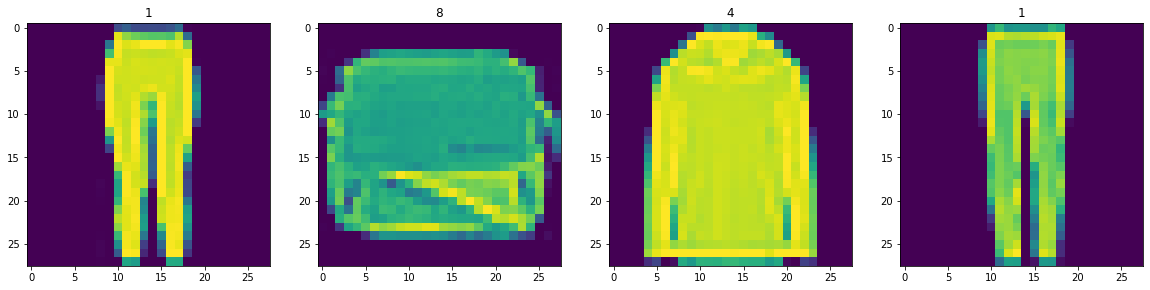

In [149]:
'''
fig -> the enitire 20x20 plot
ax -> individual subplots
'''
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    batch = data_iterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [150]:
def scale_images(data):
    '''
    Scale and return images
    '''
    image = data['image']
    return image / 255

__Typical steps in creating a data pipeline for tensorflow__
- map
- catch
- shuffle
- batch
- prefetch

In [151]:
# Reloading the dataset
ds = tfds.load('fashion_mnist', split='train')

ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(600000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [152]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## 3. Build Neural Network

### 3.1 Import Modelling Components

In [153]:
# Sequential API is used for for the generator and discriminator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

In [154]:
def build_generator():
    model = Sequential()

    # Generating based on 128 random values. 
    # Takes random values and reshapes it to 7x7x128
    # Each image dimension is 7x7? 
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128))) 
    
    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Pooling block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Pooling block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [155]:
generator = build_generator()

In [156]:
generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_28 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [157]:
'''
generating 4 images
'''
img = generator.predict(np.random.randn(4, 128, 1))

2022-06-26 13:39:14.136733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 101ms/step


In [158]:
img.shape

(4, 28, 28, 1)

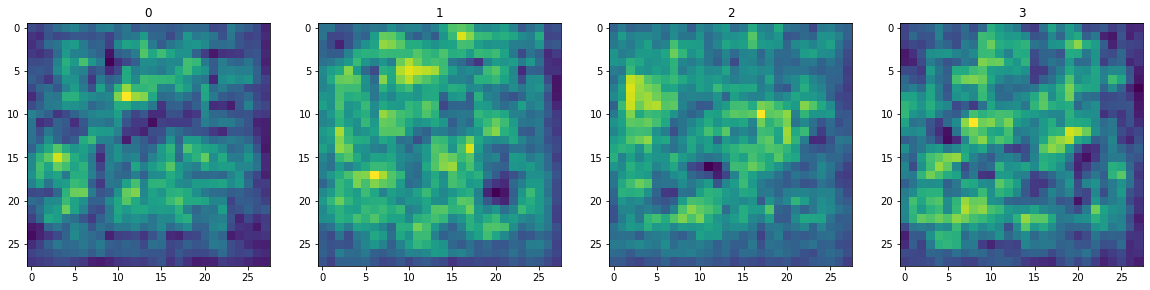

In [159]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(img):
    batch = data_iterator.next()
    ax[idx].imshow(np.squeeze(image))
    ax[idx].title.set_text(idx)

### 3.3 Build Discriminator

In [160]:
def build_discriminator():
    model = Sequential()
    
    # First conv block
    model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second conv block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third conv block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth conv block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
              
    return model

In [161]:
discriminator = build_discriminator()

In [162]:
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_19 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_20 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 16, 16, 128)     

In [163]:
img.shape

(4, 28, 28, 1)

In [164]:
discriminator.predict(img)

2022-06-26 13:39:14.539165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 76ms/step


array([[0.50219077],
       [0.5020764 ],
       [0.50215614],
       [0.50230205]], dtype=float32)

## 4. Construct Training Loop

 ### 4.1 Setup Losses and Optimizers

In [165]:
# Adam is going to bethe optimizer from both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [166]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclasses Model 

In [167]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [168]:
# TF method to generate random images
tf.random.normal((6, 128, 1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[ 1.8828582 ],
        [ 0.483769  ],
        [-1.129372  ],
        [ 0.9917406 ],
        [-0.6438201 ],
        [-0.42627296],
        [ 1.152352  ],
        [ 0.4941284 ],
        [-0.5255155 ],
        [-1.4836386 ],
        [ 0.90033877],
        [ 0.02438897],
        [-0.02182276],
        [-0.6415262 ],
        [ 0.44068035],
        [-0.7297693 ],
        [-0.54257375],
        [ 0.02309273],
        [ 1.3525469 ],
        [-0.39568788],
        [-1.8851873 ],
        [ 0.10136801],
        [ 0.14068045],
        [-0.28208762],
        [-1.3776    ],
        [-1.1117761 ],
        [ 0.7272009 ],
        [-0.48111507],
        [ 1.6491202 ],
        [ 0.55655915],
        [-1.0678287 ],
        [-0.9021193 ],
        [ 0.7321175 ],
        [ 0.527721  ],
        [-0.45525002],
        [-2.3208141 ],
        [ 0.7537093 ],
        [-0.3790749 ],
        [ 0.48904452],
        [ 0.2596532 ],
        [-0.72056866],
    

In [169]:
class fashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
        
    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = 0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - Binarycross
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
        
        # Apply backpropagation 
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [170]:
# Create instance of subclassed model
fashgan = fashionGAN(generator, discriminator)

In [171]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [172]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [173]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images += 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### 4.3 Train

In [138]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=2, callbacks=[ModelMonitor()])

Epoch 1/2
 57/469 [==>...........................] - ETA: 7:16 - d_loss: 0.6566 - g_loss: 0.6743

KeyboardInterrupt: 

### 4.4 Review Performance

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

## 5. Test Out the Generator

### 5.1 Generate Images

In [175]:
generator.load_weights('./models/generatormodel.h5')

ValueError: axes don't match array

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])